This notebook creates a very simple neuronal network model to classify MNIST samples using only fully connected layers

Also images are treated as regular 1D vectors with 784 elements (28 by 28). This model will not extract spatial patterns at all

This estimator is the baseline for the rest of the models; We need to improve its performance score

## Import statements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical

%matplotlib inline

Using TensorFlow backend.


## Load the dataset

In [2]:
data = np.load('./data/preprocessed.npz')

In [3]:
X, y = data['X'], data['y']

In [4]:
X.shape

(70000, 28, 28)

In [5]:
X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=13)
y_train_cat, y_test_cat = to_categorical(y_train), to_categorical(y_test)

## Create the model

In [7]:
model = Sequential()
model.add(Dense(units=16, input_shape=(X.shape[1],), use_bias=True, activation='relu'))
model.add(Dense(units=32, use_bias=True, activation='relu'))
model.add(Dense(units=10, use_bias=True, activation='softmax'))
model.compile(optimizer=RMSprop(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
initial_weights = model.get_weights()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 13,434
Trainable params: 13,434
Non-trainable params: 0
_________________________________________________________________


## Cross validate the model

In [8]:
def build():
    model.set_weights(initial_weights)
    return model
wrapper = KerasClassifier(build, batch_size=128, epochs=2, verbose=False)
cv = StratifiedKFold(4, shuffle=True, random_state=13)
cv_results = cross_val_score(wrapper, X_train, y_train, scoring='accuracy', cv=cv)
print('Done')

Done


In [9]:
cv_results

array([0.92707843, 0.92054316, 0.92994016, 0.9193787 ])

In [10]:
print('Accuracy score is {} +- {}'.format(np.mean(cv_results), np.std(cv_results)))

Accuracy score is 0.9242351119248268 +- 0.004411556803065858


## Final prediction on test set

In [123]:
model.set_weights(initial_weights)
history = model.fit(X_train, y_train_cat, batch_size=128, epochs=3, verbose=True)

Epoch 1/3
59500/59500 [==============================] - 4s 71us/step - loss: 0.3910 - acc: 0.8785
Epoch 2/3
59500/59500 [==============================] - 5s 76us/step - loss: 0.2187 - acc: 0.9355
Epoch 3/3
59500/59500 [==============================] - 4s 67us/step - loss: 0.1940 - acc: 0.9424


In [101]:
print('Accuracy on train set: {}'.format(model.evaluate(X_train, y_train_cat)[1].round(3)))
print('Accuracy on test set: {}'.format(model.evaluate(X_test, y_test_cat)[1].round(3)))

59500/59500 [==============================] - 5s 91us/step
Accuracy on train set: 0.956
10500/10500 [==============================] - 1s 85us/step
Accuracy on test set: 0.946


In [11]:
y_train_pred = model.predict_classes(X_train)
y_test_pred = model.predict_classes(X_test)

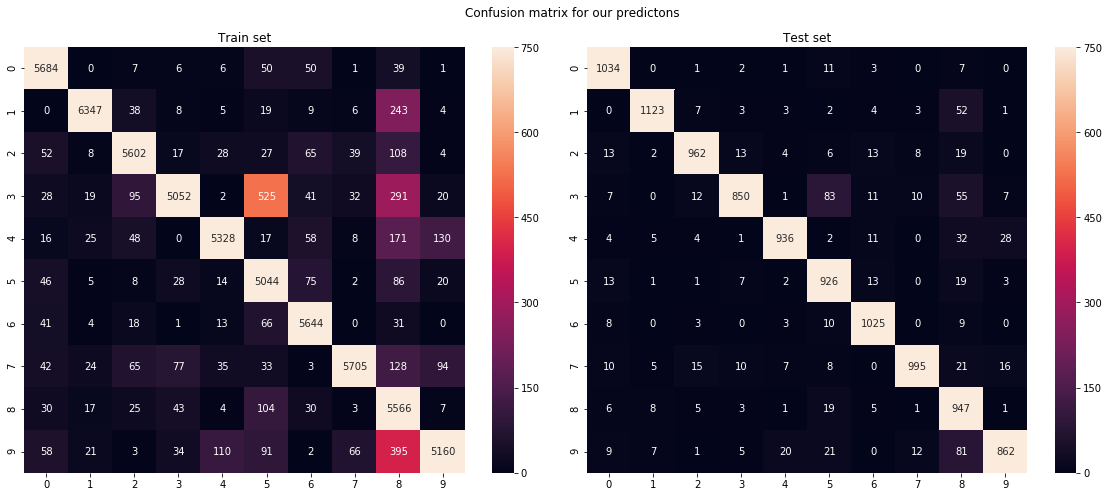

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

plt.sca(ax[0])
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, y_train_pred)), annot=True, fmt='d', vmax=750)
plt.title('Train set')

plt.sca(ax[1])
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_test_pred)), annot=True, fmt='d', vmax=750)
plt.title('Test set')

plt.suptitle('Confusion matrix for our predictons')
plt.tight_layout()
plt.subplots_adjust(top=0.9)